In [1]:
import matplotlib.pyplot as plt
import numpy as np 

In [35]:
def split_string(string): 
    return float(string.split(":,",1)[1][:-3])

def detach_tensor(tensor):
    return tensor.cpu().detach().numpy()

def parse_log(logfile):
    train_acc = []
    test_acc = []
    with open(logfile) as f:
        lines = f.readlines()


    for line in lines:
        if 'Current train acc:' in line:
            train_acc.append(split_string(line))
        if 'Current test acc' in line:
            test_acc.append(split_string(line))
    return train_acc, test_acc

def plot_metric(metric, label):
    plt.plot(np.arange(len(metric)), metric, label=label)
    
    
def plot_logfile(logfile, training_label=''):
    train_acc, test_acc = parse_log(logfile)
    plot_metric(train_acc, label=f'{training_label}_train')
    plot_metric(test_acc, label=f'{training_label}_test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')


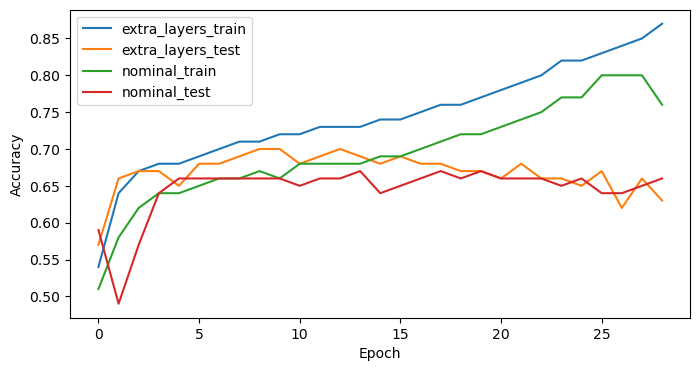

In [3]:
plt.rcParams['figure.figsize'] = (8, 4)
log_folder = '/data/rradev/supernovae_trigger/log/'
moar_layers = 'file_2022-11-07_14-01-48_611910.log'
seven_feats = 'file_2022-11-07_11-18-24_969012.log'

plot_logfile(log_folder + moar_layers, 'extra_layers')
plot_logfile(log_folder + seven_feats, 'nominal')
plt.legend()


### Compute Classification Report

In [ ]:
import torch
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from math import floor
from tqdm import tqdm
from dataset import HitsDataset

batch_size = 16
ds = HitsDataset()
train_len = floor(0.8 * len(ds))
test_len = len(ds) - train_len
generator=torch.Generator().manual_seed(42)
train_ds, test_ds = random_split(ds, lengths=[train_len, test_len], generator=generator)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [49]:
from net import Net

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('outputs/model_epoch10_acc_0.70.pth')
model = Net(7, 2).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

def test(loader):
    preds = []
    labels = []
    model.eval()
    for data in tqdm(loader):
        data = data.to(device)
        with torch.no_grad():
            pred = model(data)
        preds.append(pred)
        labels.append(data.y)
    return np.argmax(detach_tensor(torch.vstack(preds)), axis=1), detach_tensor(torch.hstack(labels))

preds, labels = test(test_loader)


100%|██████████| 237/237 [00:11<00:00, 20.02it/s]


In [51]:
from sklearn.metrics import classification_report

print(classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.75      0.63      0.68      1944
         1.0       0.67      0.78      0.72      1848

    accuracy                           0.70      3792
   macro avg       0.71      0.70      0.70      3792
weighted avg       0.71      0.70      0.70      3792

